<a href="https://colab.research.google.com/github/chanlee4345/invest/blob/main/bt_%EC%82%AC%EA%B3%84%EC%A0%88%EC%8B%9C%EC%A6%8C%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bt
!pip install finterstellar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 2.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bt: filename=bt-0.2.9-cp37-cp37m-linux_x86_64.whl size=765287 sha256=e51d392095aed53b7f73147baa532f488db181391c914e4586bb56a387846930
  Stored in directory: /root/.cache/pip/wheels/c5/1a/3f/b56e6064b766c107f25e200969161c09ca6868cbfe0eaa31e4
Successfully built bt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 3.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import bt
import finterstellar as fs
import pandas as pd
%matplotlib inline

In [3]:
U = ['SPY','IEF','TLT','GLD','DBC']
initial_capital = 100000.0

In [4]:
df = pd.DataFrame()
for ticker in U:
  df[ticker] = fs.get_ohlc(ticker, start_date='2001-01-01')['Adj Close']
df = df.dropna()
df['CASH'] = 100.00
df

,SPY,IEF,TLT,GLD,DBC,CASH
Date,,,,,,
2006-02-06,91.71,55.36,55.26,56.72,22.05,100.00
2006-02-07,90.90,55.29,55.00,54.60,21.41,100.00
2006-02-08,91.72,55.26,54.87,54.83,21.32,100.00
2006-02-09,91.57,55.31,55.12,56.18,21.52,100.00
2006-02-10,91.74,55.15,54.82,54.79,21.13,100.00
...,...,...,...,...,...,...
2022-07-28,406.07,104.95,117.54,163.64,25.99,100.00
2022-07-29,411.99,104.99,117.22,164.10,26.11,100.00
2022-08-01,410.77,105.60,120.04,165.03,25.58,100.00


# all season 전략, SPY buy & hold

In [5]:
s1 = bt.Strategy('all_season',
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 bt.algos.WeighSpecified(SPY=0.3,IEF=0.15,TLT=0.4,GLD=0.075,DBC=0.075),
                 bt.algos.Rebalance(),
                 ])
bt1 = bt.Backtest(s1, df, initial_capital=initial_capital)

In [6]:
def buy_and_hold(data, name='buy_and_hold'):
  s = bt.Strategy(name, [bt.algos.RunOnce(),
                         bt.algos.SelectAll(),
                         bt.algos.WeighEqually(),
                         bt.algos.Rebalance()])
  return bt.Backtest(s, data, initial_capital=initial_capital)

In [7]:
spy = buy_and_hold(df['SPY'].to_frame(), name='spy')

# all season 시즌제
- 11월에서 4월 사이에만 사면 된다.
  - 4월말에 매도, 10월말에 매수
- 가격 변동이 없는 CASH 자산을 임의로 만들고, 5~10월에는 CASH를 100% 보유

In [8]:
class WeighAllSeasonSeason(bt.Algo):
  def __init__(self):
    super(WeighAllSeasonSeason, self).__init__()

  def __call__(self, target):
    current_month = target.universe[['CASH']].loc[target.now].name.month
    if current_month >= 10 or current_month < 4: # invest
      weights = pd.Series([0.3,0.15,0.4,0.075,0.075],
                          ['SPY','IEF','TLT','GLD','DBC'])
    else: # rest. all cash
      weights = pd.Series([1.0], ['CASH'])

    target.temp['weights'] = weights
    target.temp['selected'] = list(weights.index)

    return True

In [9]:
s2 = bt.Strategy('all_season_season',
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 WeighAllSeasonSeason(),
                 #bt.algos.PrintTempData(),
                 bt.algos.Rebalance(),
                 ])
bt2 = bt.Backtest(s2, df, initial_capital=initial_capital)

In [27]:
class WeighAllSeasonSeasonSPYOnly(bt.Algo):
  def __init__(self):
    super(WeighAllSeasonSeasonSPYOnly, self).__init__()

  def __call__(self, target):
    current_month = target.universe[['CASH']].loc[target.now].name.month
    if current_month >= 10 or current_month < 4: # invest
      weights = pd.Series([0.3,0.15,0.4,0.075,0.075],
                          ['SPY','IEF','TLT','GLD','DBC'])
    else: # rest. SPY 대신 CASH
      weights = pd.Series([0.3,0.15,0.4,0.075,0.075],
                          ['CASH','IEF','TLT','GLD','DBC'])

    target.temp['weights'] = weights
    target.temp['selected'] = list(weights.index)

    return True

In [28]:
s3 = bt.Strategy('all_season_season_SPY_only',
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 #bt.algos.PrintDate(),
                 bt.algos.SelectAll(),
                 WeighAllSeasonSeasonSPYOnly(),
                 #bt.algos.PrintTempData(),
                 bt.algos.Rebalance(),
                 ])
bt3 = bt.Backtest(s3, df, initial_capital=initial_capital)

In [29]:
res = bt.run(bt3, bt2, bt1, spy)

In [30]:
res.display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec     YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------
  2006   0      0.17  -1.06   0.6   -0.22   0.09   1.52   1.13   0.29   0.59   2.72  -1.18    4.7
  2007   0      1.65  -0.39   1.99  -1.32  -0.56   1.98   0.99   1.6    2.04   1.41   0.42   10.19
  2008   0.55   0.46   0.27   0.21  -0.75   2.35  -0.88   0.14   0.11  -3.96   4.82   6.85   10.21
  2009  -8.18  -4.26   4.77  -0.47   0.2   -0.37   0.67   0.71   1.57  -0.27   3.93  -3.17   -5.43
  2010  -0.34   1.4    0.78   2.77   1.95   2.82  -0.16   4.05  -0.01  -1.18  -0.69   0.94   12.89
  2011  -0.75   2.43   0.31   3.09   1.22  -1.5    3.21   5.45   3.69  -0.71   0.86   0.98   19.62
  2012   2.52   0.28  -1.2    1.99   2.73  -0.41   2.23   0.25  -0.75  -0.77   0.89  -1.13    6.72
  2013   0.21   0.32   1.13   1.83  -3.75  -2.72  -0.16  -0.15  -0.07   0.66  -0.8   -0.52   -4.09
  2014   1.

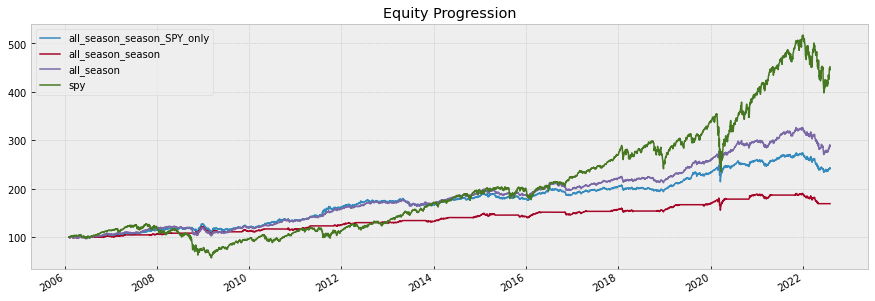

In [31]:
res.plot()

In [32]:
res.display()

Stat                 all_season_season_SPY_only    all_season_season    all_season    spy
-------------------  ----------------------------  -------------------  ------------  ----------
Start                2006-02-05                    2006-02-05           2006-02-05    2006-02-05
End                  2022-08-03                    2022-08-03           2022-08-03    2022-08-03
Risk-free rate       0.00%                         0.00%                0.00%         0.00%

Total Return         142.07%                       69.05%               189.41%       351.79%
Daily Sharpe         0.76                          0.60                 0.88          0.56
Daily Sortino        1.24                          0.90                 1.41          0.86
CAGR                 5.51%                         3.24%                6.66%         9.58%
Max Drawdown         -14.71%                       -13.88%              -17.15%       -55.17%
Calmar Ratio         0.37                          0.23         